In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import collections
from sklearn import preprocessing, svm, tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
import spacy
nlp = spacy.load("en_core_web_sm", disable=['attribute_ruler',"parser",'lemmatizer','ner'])
import json
import time

# Loading and Preparing Data

#### Loading Labelled Article Data

In [381]:
# Loading cleaned, labelled article data as a Pandas dataframe
data = pd.read_excel("../../Data/cleaned_data/Labelled_VR_data_Oct2020_Jan2021_wfulltext.xlsx")

#### Loading the MPQA Subjectivity Clues Lexicon (https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)

In [382]:
# Subjectivity Dictionary
mpqa_dict = json.load(open("resources/mpqa_dict.json", "r"))

#### Filter data

In [383]:
#Filter out LTEs and Spanish language articles
data = data[(data['opinion_type'] != "Letter") | data["Full Text"].str.contains(" por ")].copy()

### Pre-processing

#### Converting Article Status to an Indicator Variable

In [384]:
# Converting article status strings to article status indicators.
# 1 = Opinion, 0 = News
data["Article Status Int"] = data["Article Status"].replace(["Opinion","News"],["1","0"]).astype('int')

#### Process text and metadata columns

In [385]:
# Cleaning string-based columns by filling na values with empty strings, make lower case if needed
data["fulltext"] = data["Full Text"].fillna("").str.lower()
data["journ_name"] = data["Journalist Name"].fillna("").str.lower()
data["Headline"] = data["Headline"].fillna("").str.lower()
data["Cleaned Author"].fillna("", inplace =True)

#Create full text column w/o quotes (pattern looks for at least 15 characters within the quote marks)
data['fulltext_noquote'] = data['fulltext'].str.replace("\".{15,200}\"|\“.{15,200}?\”", "", regex=True)

### Functions for feature extraction

In [386]:
def create_feature_from_terms(term_list, column, df):
    '''(List, series, df -> df) loop through (lower-case) list of terms, check for presence of that term in the specified column, 
    and create feature column where 1 denotes presence of the term'''
    
    for item in term_list:
        df[re.sub(" ", "_", item) + "_" + re.sub(" ", "_", column) + "_" + "feature"] = np.where(df[column].str.contains(item), 1, 0)
    
    return df


# linguistic features — SENTIMENT — OPINION
# calculated in study using MPQA Subjectivity Clues Lexicon 

def get_sentiment(art_str, mpqa_dict):
    subjectivity, adjectives, sub_adjectives = 0, 0, 0
    words = re.sub("[^\w]", " ",  art_str).split()
    
    for w in words:
        if w in mpqa_dict:  
            if mpqa_dict[w]['subj'] == 'weaksubj':
                subjectivity += 0.1
            if mpqa_dict[w]['subj'] == 'strongsubj':
                subjectivity += 1
            if mpqa_dict[w]['pos'] == 'adj' :
                adjectives += 1
                if mpqa_dict[w]['subj'] == 'weaksubj':
                    sub_adjectives += 0.1
                if mpqa_dict[w]['subj'] == 'strongsubj':
                    sub_adjectives += 1
    
    return subjectivity, sub_adjectives


### Regex Patterns for feature extraction

In [387]:
#Heuristic features
name_terms = ["editor", "staff writer", "staff", "news"]

headline_terms = ["opinion", "editor", "editorial", "column", "news", "fact check"]

fulltext_terms = ["editorial board", "columnist", "associated press", "reuters", "staff writer",
                  "staff writers", "staff", "bureau", "contributed", "compiled by", "correspondent"]


#linguistic features — Negations
negations = r'\b(?:no|not|none|no one|nobody|neither|nowhere|nothing|never)\b'
neg_suffix = "n\'t"

# linguistic features — PRONOUNS outside of quotes — OPINION
# study used first and second person only
first_person = r'\b(?:I|we|our|ourselves|us|me|my|mine|myself)\b'
second_person = r'\b(?:you|yours|your|yourself|yourselves)\b'
third_person = r'\b(?:he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves)\b'

# linguistic features — CONNECTIVES (Temporal, Casual, Contrastive, Expansive)
# hypothesis being that there are more connectives in news (aftermath of study)
# casual, expansive, temporal, contrastive — NEWS 
causal = r'\b(?:after|because|insofar as|by|in turn|for|once|as a result|hence|in the end|by then|but|subsequently|as|therefore|unless|thus|accordingly|so that|since|consequently|indeed|ultimately|then|even though|now that|finally|hence|if|although|so|thereby|otherwise|due to|and|when)\b'

contrastive = r'\b(?:nor|in fact|despite|equally|by comparison|contrast|by contrast|but|separately|whereas|rather|meanwhile|also|even so|and|though|if|unlike|however|or|then|nevertheless|yet|even though|conversely|nonetheless|on the contrary|in contrast|while|likewise|instead|although|on the other hand|still|similarly|otherwise|actually|alternatively|on the one hand|when)\b'

temporal = r'\b(?:before|after|next|shortly|afterwards|eventually|firstly|secondly|previously|meanwhile|finally|while|then|earlier|when|initially|soon|suddenly|until|once|recently|already|as)\b'

expansive = r'\b(?:also|and|as well as|besides|in addition|furthermore|in fact|moreover|additionally|too|further|or|neither|nor|either)\b'


# linguistic features — MODALS — OPINION
# hypothesis being that modal verbs are expected to be a better indicator for opinion 
# according to study, is less potent but do correspond to the genre as expected
modals = r'\b(?:can|must|may|could|might|should|would|shall|ought to)\b'

# linguistic features — VERBSofSAYING (VoS) — NEWS
# hypothesis that vos more common in news
vos = r'\b(?:acknowledged|affirmed|alleged|announced|asserted|claimed|commented|contended|declared|disclosed|exclaimed|explained|insisted|mentioned|notified|observed|proclaimed|proposed|remarked|reported|revealed|said|stated|stipulated|told|wrote)\b'

# Feature Extraction

Credit: Shiny Weng

#### Metadata features

In [388]:
# Author count feature
# News articles tend to have slightly more authors
data["author_count_feature"] = data["Cleaned Author"].str.count(", ") + 1

# Headline length feature
# On average, news headlines are slightly longer than opinion headlines
data["headline_length_feature"] = data["Headline"].str.len()

#Heuristics - Create dummy-coded (0/1) feature columns from terms lists
data = create_feature_from_terms(name_terms, "journ_name", data)
data = create_feature_from_terms(headline_terms, "Headline", data)

#Should
data["hdl_should_feature"] = np.where(data["Headline"].str.contains(r"\b(?:should)\b"), 1, 0)


#### Full text features

In [389]:
#Heuristics - Create dummy-coded (0/1) feature columns from terms lists
data = create_feature_from_terms(fulltext_terms, "fulltext", data)

#Mr/Mrs/Ms
data["mr_feature"] = data["fulltext"].str.count("mr.|mrs.|ms.")

#Digits
data["digits_feature"] = data["fulltext"].str.count("[\d]+")/data["fulltext"].str.len()

#Questions
data["questions_feature"] = data["fulltext"].str.count("\?")/data["fulltext"].str.len()
#Commas
data["commas_feature"] = data["fulltext"].str.count(",")/data["fulltext"].str.len()
#Semi-colons
data["semicolons_feature"] = data["fulltext"].str.count(";")/data["fulltext"].str.len()
#Periods
data["periods_feature"] = data["fulltext"].str.count("\.")/data["fulltext"].str.len()


#Negations
data["negations_feature"] = data["fulltext"].str.count(negations)/data["fulltext"].str.len()
#Negation suffix
data["negation_suffix_feature"] = data["fulltext"].str.count(neg_suffix)/data["fulltext"].str.len()


#1st/2nd/3rd person
data["first_person_feature"] = data["fulltext_noquote"].str.count(first_person)/data["fulltext_noquote"].str.len()
data["second_person_feature"] = data["fulltext_noquote"].str.count(second_person)/data["fulltext_noquote"].str.len()
data["third_person_feature"] = data["fulltext_noquote"].str.count(third_person)/data["fulltext_noquote"].str.len()
data["first_second_person_feature"] = data["first_person_feature"] + data["second_person_feature"]

#Future tense
data["future_feature"] = data["fulltext_noquote"].str.count(r"\bwill\b")/data["fulltext_noquote"].str.len()

#Connectives
data["temporal_feature"] = data["fulltext"].str.count(temporal)/data["fulltext"].str.len()
data["causal_feature"] = data["fulltext"].str.count(causal)/data["fulltext"].str.len()
data["contrastive_feature"] = data["fulltext"].str.count(contrastive)/data["fulltext"].str.len()
data["expansive_feature"] = data["fulltext"].str.count(expansive)/data["fulltext"].str.len()

#Citations
data["citation_feature"] = data["fulltext"].str.count("\".{10,200}?\"|\“.{10,200}?\”")/data["fulltext"].str.len()
#Get list of quotes then find average length
data["citation_length_feature"] = data["fulltext"].str.findall("\".*?\"|\“.*?\”").apply(lambda x: np.mean([len(y) for y in x])).fillna(0)

#VOS
data["vos_past_feature"] = data["fulltext"].str.count(vos)/data["fulltext"].str.len()

#Said
data["said_feature"] = data["fulltext"].str.count("said")

#Said
data["say_feature"] = data["fulltext"].str.count("says?")

data["spokesperson_feature"] = data["fulltext"].str.count("spokesperson|spokesman|spokeswoman|for comment")

#Modals
data["modals_feature"] = data["fulltext"].str.count(modals)/data["fulltext"].str.len()

#Subjectivity
data["subjectivity"] = data["fulltext_noquote"].apply(get_sentiment, mpqa_dict=mpqa_dict)
data[['subjectivity_feature','adj_subjectivity_feature']] = pd.DataFrame(data["subjectivity"].tolist(), index= data.index)


/Users/lauranixon/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [390]:
#These Journalist Name terms are only found in opinion articles
name_only_opinion = ["opinion", "letters? to the editor", "letters\:", "editorial board", "readers", "columnist"]

#These Headline terms are only found in opinion articles
headline_only_opinion = ["letters? to the editor", "letters\:", "columnist"]

#These Full Text terms are only found in opinion articles
fulltext_only_opinion = ["letters? to the editor"]


#These Journalist Name terms are only found in news articles
name_only_news = ["contributed", "bureau", "compiled by"]

#These Full Text terms are only found in news articles
fulltext_only_news = ["\(ap\)", "contributed to this report"]


#Create column for articles matching news-only regex patterns
#or associated press in name field where headline does not equal 'editorial roundup'
data["news_rule_feature"] = np.where(((data["fulltext"].str.contains("|".join(fulltext_only_news), regex=True))|
                           (data["journ_name"].str.contains("|".join(name_only_news), regex=True))|
                           ((data["journ_name"].str.contains("associated press")) & 
                            -(data["Headline"].str.contains("editorial roundup")))), 
                          1, 0)

#Create column for articles matching opinion-only regex patterns
data["opinion_rule_feature"] = np.where(((data["fulltext"].str.contains("|".join(fulltext_only_opinion), regex=True))|
                              (data["journ_name"].str.contains("|".join(name_only_opinion), regex=True))|
                               (data["Headline"].str.contains("|".join(headline_only_opinion), regex=True))),
                              1, 0)


# Train Test Split

In [398]:
#Identify feature columns
data_wfeats = data.loc[:, (data.columns.str.endswith("_feature"))].copy()

#Set up target data
y = np.array(data["Article Status Int"])
y_col = ['art_status']
data_wfeats['art_status'] = y

In [399]:
# Train test split for articles in our dataset
train, test = train_test_split(data_wfeats, test_size=0.30, random_state=42)

In [400]:
X_cols = list(train.drop(["art_status"], axis=1).columns)
feature_names = X_cols

In [401]:
# Defining the data matrix and label vector for train and test data sets
X_train = train.drop(["art_status"], axis=1).to_numpy()
y_train = train[y_col].to_numpy().flatten()

X_test = test.drop(["art_status"], axis=1).to_numpy()
y_test = test[y_col].to_numpy().flatten()

### Normalize features with MinMax scaling

In [402]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing data
X_test = norm.transform(X_test)

# Preparing Model Evaluation Tools

Credit: Daniel Chung

NOTE: We prefer false positives to false negatives, meaning we prioritize higher recall over a higher specificity

In [403]:
y_true = y_test

In [404]:
# Defining a helper function to evaluate AUC and plot ROC curve for the SVM and Naive Bayes models
def assess_roc(model, y_score, model_name):
    """Inputs:
       - model: fitted model to be evaluated
       - y_score: the model's predicted probabilities for the data belonging to class 1
       - model_name: arbitrary string to identify model
       Outputs:
       - prints model AUC score
       - plots model ROC curve"""
    
    # Computing ROC curve and ROC area for opinion class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plotting
    plt.figure(figsize=[12,8])
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--");
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel("False Positive Rate");
    plt.ylabel("True Positive Rate");
    plt.title("Receiver Operating Characteristic for " + model_name + " Model");
    plt.legend(loc="lower right");
    plt.show();
    print("----------------------------------------------------")
    print("AUC: " + str(roc_auc))

In [405]:
# Creating a helper function that prints a report of model quality metrics given any model
def report_quality(model, model_name, threshold=0.5, tree=False):
    
    # Acquire model predictions
    if tree:
        y_pred = model.predict(X_test)
    else:
        y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
    
    # Begin calculating model quality metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Report model quality 
    print("=============================================")
    print("Quality Report for " + model_name + " Model:")
    print("---------------------------------------------")
    print("Accuracy:    " + str(accuracy))
    print("F1 Score:    " + str(f1))
    print("Recall:      " + str(recall))
    print("Specificity: " + str(specificity))
    print("=============================================")
    
    #return y_pred
    

In [406]:
# For models that use decision probability thresholds, we created a helper function
# that plots accuracy, f1, recall, and specificity for possible threshold values between 0 and 1
def assess_thresholds(model, model_name, threshold_proposal=0.5):
    """Inputs:
       - model: model object 
       - model_name: string identifier of model object, could be anything
       - threshold proposal: proposed threshold value, will be included in the final plot
       Outputs:
       - a plot showing how different threshold values affect accuracy, f1, recall, and specificity"""
    # Calculating model quality metrics for each threshold we are trying
    try_thresholds = np.linspace(0,1,100)
    recalls = []
    specificities = []
    accuracies = []
    f1s = []
    for threshold in try_thresholds:
        try_y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, try_y_pred).ravel()
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)
        accuracy = accuracy_score(y_true, try_y_pred)
        f1 = f1_score(y_true, try_y_pred, average='macro')
        
        recalls.append(recall)
        specificities.append(specificity)
        accuracies.append(accuracy)
        f1s.append(f1)
        
    # Plotting the results
    plt.figure(figsize=[12, 8]);
    plt.plot(try_thresholds, recalls, label="Recall");
    plt.plot(try_thresholds, specificities, label="Specificity");
    plt.plot(try_thresholds, accuracies, label="Accuracy");
    plt.plot(try_thresholds, f1s, label="F1 Score");
    plt.plot(np.ones(50)*threshold_proposal, np.linspace(0,1))
    plt.title("Recall, Specificity, Accuracy, and F1 Score by " + model_name + " Decision Threshold");
    plt.xlabel("Classification Decision Threshold");
    plt.legend();

# Model 1: SVM Classifier

Credit: Daniel Chung

### Model Fitting

In [419]:
# Fitting a support vector classifier on X_train and y_train
svc = svm.SVC(C=1, kernel='linear', probability=True)
svc.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True)

### Model Evaluation

In [420]:
#xtest = pd.DataFrame(X_test, columns=X_cols)
#ypred = pd.Series(y_pred)
#ytest = pd.Series(y_test)
#pd.concat([xtest, ytest],axis=1).head(60)

In [421]:
# Assessing model quality
predictions = report_quality(svc, "SVM Classifier", threshold=0.15)

Quality Report for SVM Classifier Model:
---------------------------------------------
Accuracy:    0.9216241737488197
F1 Score:    0.8687902767141814
Recall:      0.926829268292683
Specificity: 0.9206703910614525


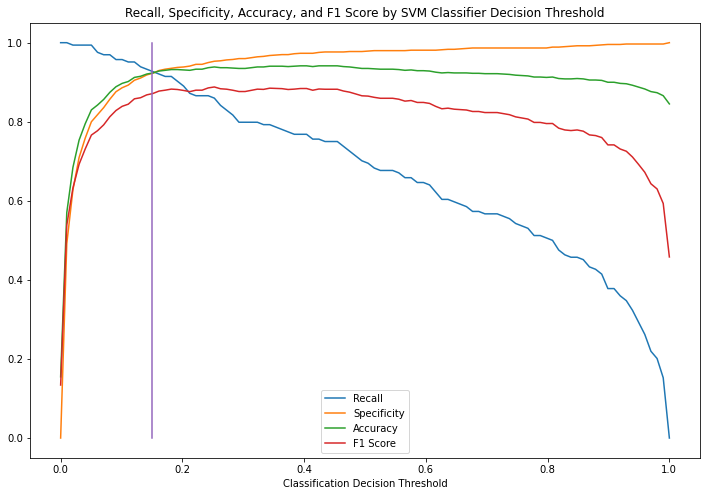

In [422]:
# Determining optimal decision threshold
assess_thresholds(svc, "SVM Classifier", 0.15)

For our SVM classifier, 0.14 is the best decision threshold that minimizes false negatives (maximizes recall) while avoiding a steep drop in accuracy.

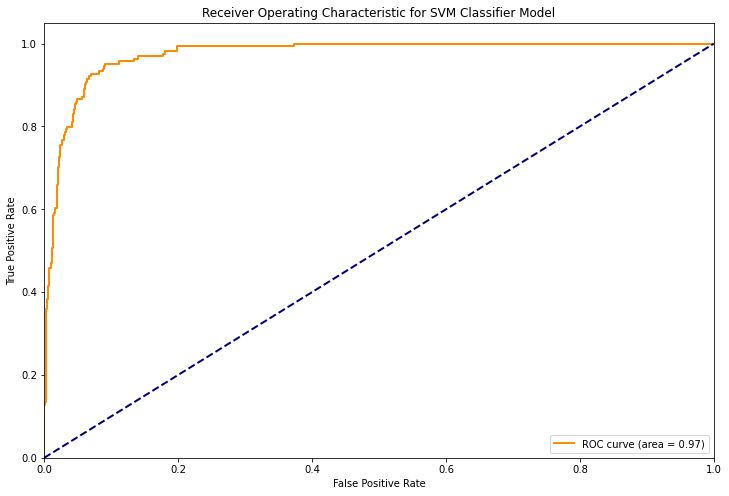

----------------------------------------------------
AUC: 0.9741722305491212


In [423]:
# Plotting ROC curve and determining AUC score
y_score = svc.decision_function(X_test)
assess_roc(svc, y_score, "SVM Classifier")

### Model Weight Investigation

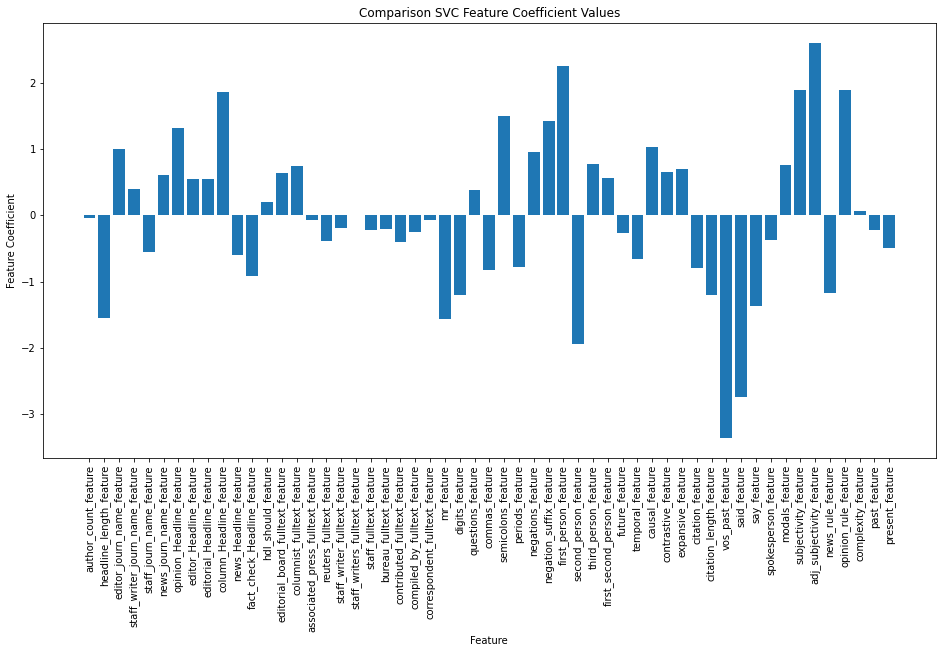

In [424]:
# Identifying coefficient importance
svc_coefs = svc.coef_.flatten()
# Plotting coefficient importance
plt.figure(figsize=[16,8]);
plt.bar(x=X_cols,height=svc_coefs);
plt.xticks(rotation='90');
plt.ylabel("Feature Coefficient");
plt.xlabel("Feature");
plt.title("Comparison SVC Feature Coefficient Values");

# Model 2: Naive Bayes Classifier

Credit: David Koo

### Model Fitting

In [425]:
from sklearn.naive_bayes import GaussianNB

In [426]:
# Fitting a gaussian naive Bayes classifier on X_train and y_train
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

### Model Evaluation

In [427]:
# Assessing model quality
report_quality(gnb, "Naive Bayes Classifier", 1)

Quality Report for Naive Bayes Classifier Model:
---------------------------------------------
Accuracy:    0.9121813031161473
F1 Score:    0.8125831355840281
Recall:      0.5914634146341463
Specificity: 0.9709497206703911


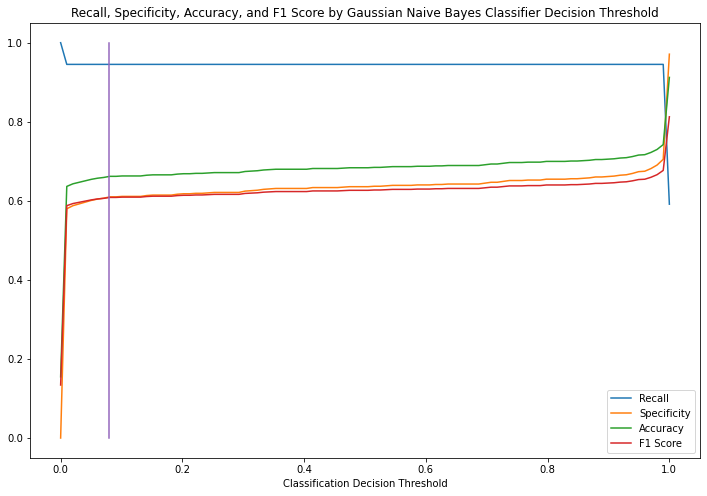

In [428]:
# Identifying optimal threshold value
assess_thresholds(gnb, "Gaussian Naive Bayes Classifier", 0.08)

For our naive Bayes classifier, there is no decision threshold that can maintain a high recall score without significantly dropping model accuracy. We use a decision threshold of 0.06, therefore, because while accuracy remains relatively constant for different threshold values, recall increases for lower thresholds.

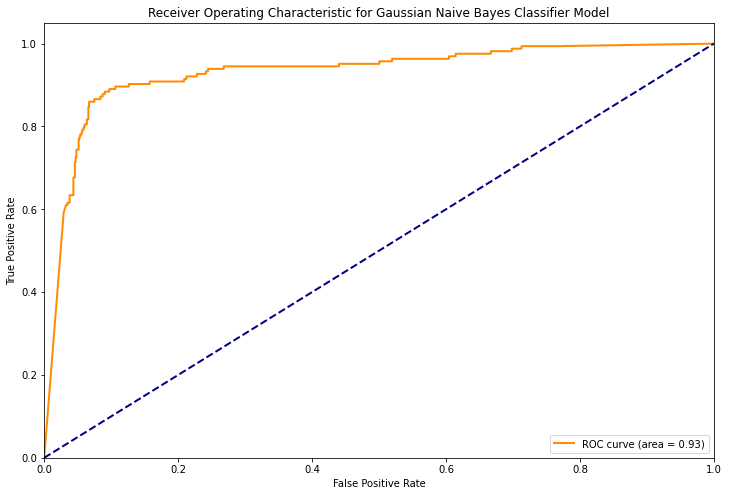

----------------------------------------------------
AUC: 0.930058591088704


In [429]:
# Plotting ROC curve and determining AUC score
y_score = gnb.predict_proba(X_test)[:,1]
assess_roc(gnb, y_score, "Gaussian Naive Bayes Classifier")

### Model Weight Investigation

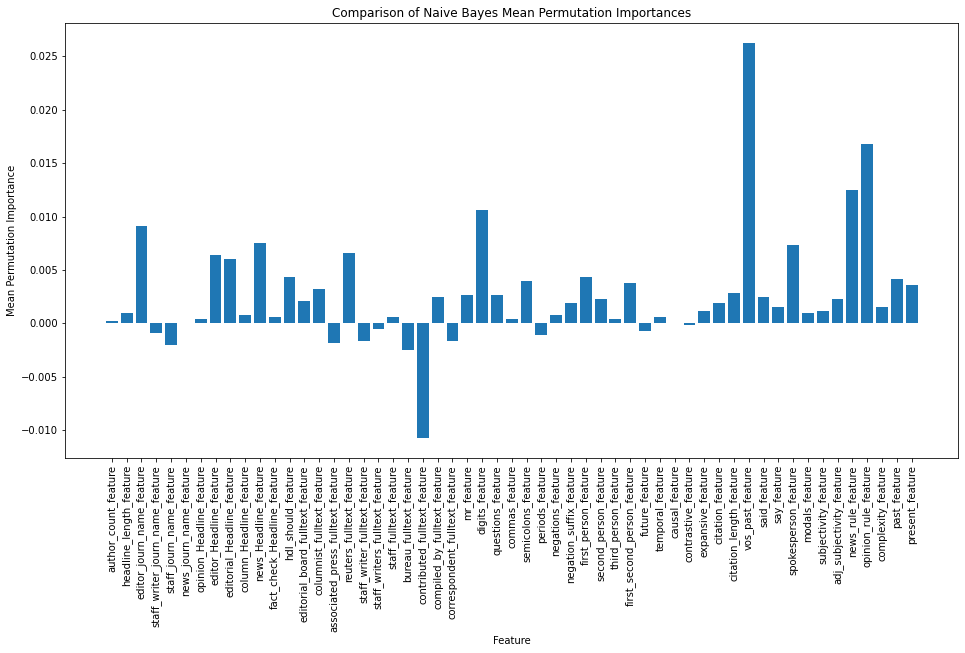

In [430]:
from sklearn.inspection import permutation_importance

# Identifying permutation importance
imps = permutation_importance(gnb, X_test, y_test)
imps_means = imps.importances_mean
# Plotting permutation importance
plt.figure(figsize=[16,8]);
plt.bar(x=X_cols, height=imps_means);
plt.title("Comparison of Naive Bayes Mean Permutation Importances");
plt.ylabel("Mean Permutation Importance");
plt.xlabel("Feature");
plt.xticks(rotation=90);

# Model 3: Tree Classifiers

Credit: Shiny Weng

In [431]:
# Defining a helper function to calculate feature importance after fitting each model
def feature_importance(feature_names, tree):
    """
    Return feature importance as a dataframe.
    """
    decision_importance = tree.feature_importances_
    importances = pd.DataFrame(data = feature_names)
    importances[1] = decision_importance
    importances = importances.T
    importances.drop(0, axis = 0, inplace = True)
    importances.columns = feature_names
    return importances 

## Extra Trees Classifier

### Model Fitting

In [432]:
from sklearn.ensemble import ExtraTreesClassifier

In [433]:
# Fitting a extra tree classifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy',  max_features = 26)
extra_tree_forest.fit(X_train, y_train)

y_pred = extra_tree_forest.predict(X_test)

### Model Evaluation

In [434]:
# Assessing model quality
report_quality(extra_tree_forest, "Extra Tree Classifier", tree=True)

Quality Report for Extra Tree Classifier Model:
---------------------------------------------
Accuracy:    0.9414542020774316
F1 Score:    0.8789401873294491
Recall:      0.7195121951219512
Specificity: 0.982122905027933


### Model Weight Investigation

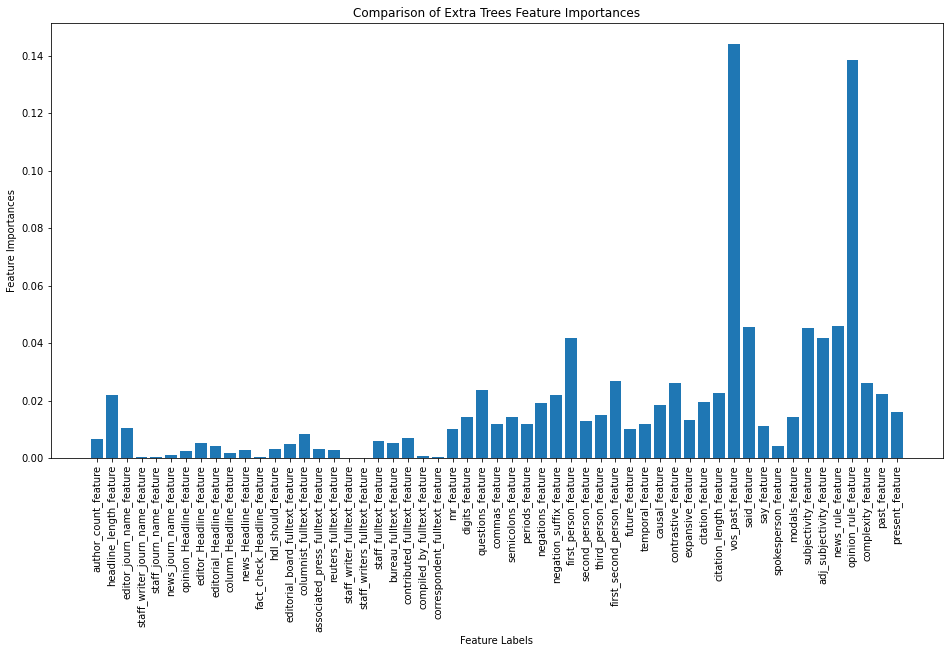

In [435]:
# Identifying feature importance
etree_importances_df = feature_importance(feature_names, extra_tree_forest)
# Bar Chart of Feature Importance (Decision)
plt.rcParams["figure.figsize"] = (16,8)
plt.bar(feature_names, etree_importances_df.to_numpy()[0])
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of Extra Trees Feature Importances')
plt.xticks(rotation=90)
plt.show()

## Random Forest Classifier

### Model Fitting

In [436]:
from sklearn.ensemble import RandomForestClassifier

In [437]:
# Fitting a random forest classifier
random_forest = RandomForestClassifier(n_estimators = 225) 
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

### Model Evaluation

In [438]:
# Assessing model quality
report_quality(random_forest, "Random Forest Classifier", tree=True)

Quality Report for Random Forest Classifier Model:
---------------------------------------------
Accuracy:    0.9348441926345609
F1 Score:    0.8617600708311499
Recall:      0.6707317073170732
Specificity: 0.9832402234636871


### Model Weight Investigation

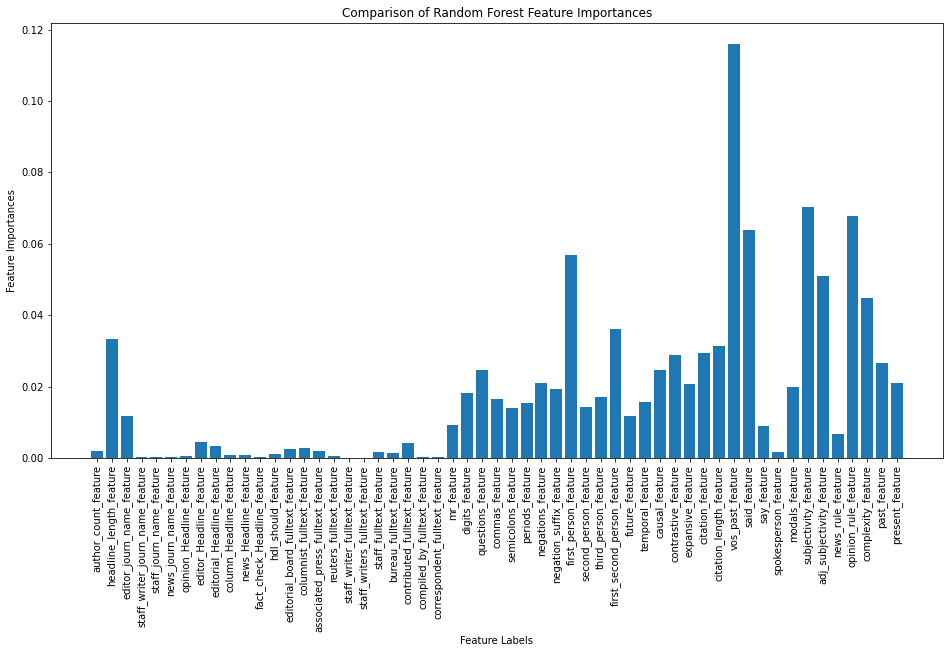

In [439]:
# Identifying feature importance
rforest_importances_df = feature_importance(feature_names, random_forest)
# Bar Chart of Feature Importance (Decision)
plt.rcParams["figure.figsize"] = (16,8)
plt.bar(feature_names, rforest_importances_df.to_numpy()[0])
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of Random Forest Feature Importances')
plt.xticks(rotation=90)
plt.show()

### Combined Model Weight Investigation

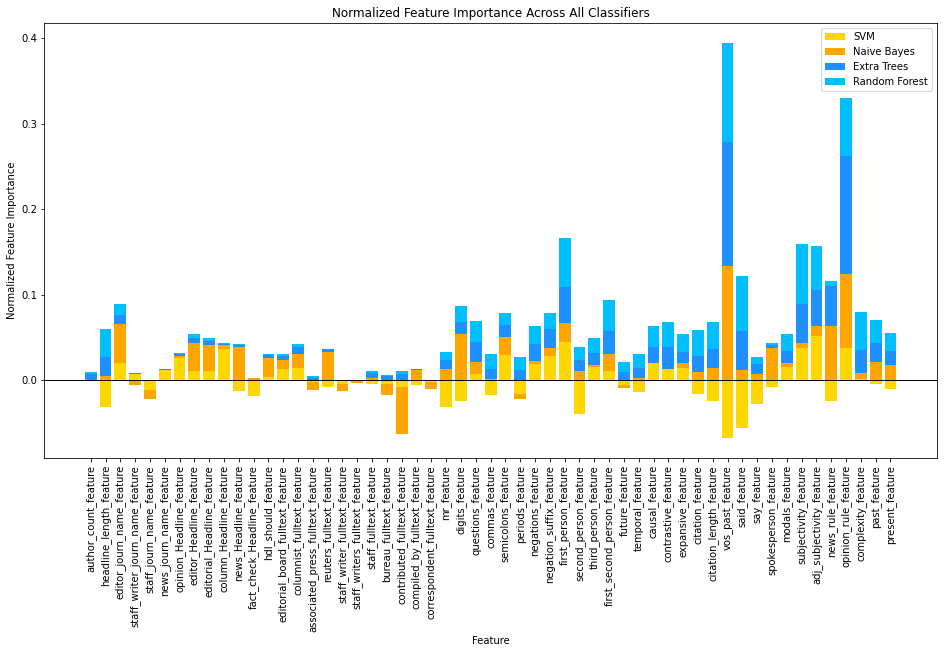

In [442]:
# Stacked bar plot visualization code from stack overflow:
# https://stackoverflow.com/questions/35979852/
# stacked-bar-charts-using-python-matplotlib-for-positive-and-negative-values

svc_importances_normed = svc_coefs / sum(np.abs(svc_coefs))
gnb_permutations_normed = imps_means / sum(np.abs(imps_means))
etree_importances_normed = etree_importances_df.to_numpy()[0] / sum(np.abs(etree_importances_df.to_numpy()[0]))
rtree_importances_normed = rforest_importances_df.to_numpy()[0] / sum(np.abs(rforest_importances_df.to_numpy()[0]))

data = np.array([svc_importances_normed,
                 gnb_permutations_normed,
                 etree_importances_normed,
                 rtree_importances_normed])

data_shape = np.shape(data)

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d  

cumulated_data = get_cumulated_array(data, min=0)
cumulated_data_neg = get_cumulated_array(data, max=0)

# Re-merge negative and positive data.
row_mask = (data<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

cols = ["gold", "orange", "dodgerblue", "deepskyblue", "lightskyblue"]

fig = plt.figure()
ax = plt.subplot(111)

label_dict = {0:"SVM",1:"Naive Bayes",2:"Extra Trees",3:"Random Forest"}

for i in np.arange(0, data_shape[0]):
    ax.bar(feature_names, data[i], bottom=data_stack[i], color=cols[i], label=label_dict[i])
plt.axhline(y=0,linewidth=1, color='k')
plt.legend()
plt.xticks(rotation=90)
plt.title("Normalized Feature Importance Across All Classifiers")
plt.ylabel("Normalized Feature Importance")
plt.xlabel("Feature")
plt.show()

In [ ]:
#This doesn't seem to match up the labels correctly
testpred = pd.concat([test.reset_index(),ypred], axis=1)
idlist = testpred["Article ID"].to_list()
test_meta = data[data["Article ID"].isin(idlist)]
allpred = pd.concat([ypred, test_meta.reset_index()], axis=1)

In [ ]:
ypred.value_counts()

In [ ]:
allpred.groupby(["Article Status", 0]).size()

In [ ]:
#allpred.to_excel("SVMpredictions_211216.xlsx")